In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
#Veri setinin yüklenmesi
dataset = pd.read_csv('BertTurkishSA_ML.csv' , sep=';',  engine='python', encoding='cp1254') 
dataset.head() 

,Sentiment,Sentence
0,0,Hayatta küçük şeyleri kovalıyor ve yine küçük ...
1,0,Seydiu şimdi iki mevkiyi de kaybetti.
2,0,"Fakat öte yandan, hayatta gelişim sağlayabilme..."
3,1,Seferler Haziran ayında başlıyor.
4,0,Siyasette temiz insanlara ihtiyacımız var.


In [53]:
#Veri Temizleme İşlemleri

#küçük harfe çevirme
dataset['Sentence'] = dataset['Sentence'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#noktalama işaretlerini kaldırma
dataset['Sentence'] = dataset['Sentence'].str.replace('[^\w\s]','')
#sayıları ayıklama
dataset['Sentence'] = dataset['Sentence'].str.replace('\d','')
#durak kelimeler
sw = stopwords.words('turkish')
dataset['Sentence'] = dataset['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
# ender(rare) kelimeler
remove = pd.Series(" ".join(dataset["Sentence"]).split()).value_counts()[-1000:]
dataset["Sentence"]=dataset["Sentence"].apply(lambda x: " ".join(i for i in x.split() if i not in remove))

In [54]:
#Veri seti eğitim ve test verileri olmak üzere ayrılır.

X_train, X_test, y_train, y_test = train_test_split(dataset["Sentence"],dataset["Sentiment"], test_size = 0.15, random_state = 42)

print(f"Eğitim Veri Sayısı : {X_train.shape[0]} Test Veri Sayısı : {X_test.shape[0]}") 



Eğitim Veri Sayısı : 4250 Test Veri Sayısı : 751


In [55]:
#Vektörizasyon işlemleri için CountVectorizer kullanılmıştır.
#CountVectorizer, bir metin belgesi koleksiyonunu bir belirteç sayısı matrisine dönüştürür.
#CountVectorizer’de terim farklı dökümanlarda geçse dahi o kelimenin geçtiği miktarı matriste belirtir. 

vectorizer = CountVectorizer() 
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [56]:
#Eğitim ve test verileri üzerinde CountVectorizer ile vektörizasyon işlemi yapılmıştır.

x_train_count = vectorizer.transform(X_train)
x_test_count = vectorizer.transform(X_test)

In [57]:
#Vektörizasyon işlemleri için kullanılan bir diğer dönüştürücü ise TF-IDF(Terim Frekansı x Ters Belge Frekansı)'dir.
#TF-IDF'nin amacı, bir belgede sık görülen ancak belgeler arasında olmayan sözcükleri vurgulamaktır.
#TF-IDF,bir kelimenin bulunduğu doküman içindeki değerini gösteren istatistiki yöntemle hesaplanan ağırlık faktörüdür.

tf_idf = TfidfVectorizer()
tf_idf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [58]:
#Eğitim ve test verileri üzerinde TF-IDF ile vektörizasyon işlemi yapılmıştır.

x_train_tf_idf = tf_idf.transform(X_train)
x_test_tf_idf = tf_idf.transform(X_test)

### **Makine Öğrenmesi** **Modelleri** 


**1 - Naive Bayes**

In [60]:
nb = MultinomialNB()  #NaiveBayes
nb_model = nb.fit(x_train_count,y_train)

y_pred = nb_model.predict(x_test_count) #counvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75       431
           1       0.68      0.55      0.61       320

    accuracy                           0.70       751
   macro avg       0.69      0.68      0.68       751
weighted avg       0.70      0.70      0.69       751



In [61]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = nb.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

In [62]:
#Karmaşıklık matrisi fonksiyonu
def plot_confusion_matrix(cm, classes,             
                          normalize=False,
                         title="Karmaşıklık Matrisi",
                         cmap = plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/ cm.sum(axis=1)[:,np.newaxis]
        print("Normalleştirilmiş Karmaşıklık Matrisi")
    else:
        print("Normalleştirme Olmadan Karmaşıklık Matrisi")
    
    print(cm)
    
    thresh=cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel("Gerçek Değerler")
    plt.xlabel("Tahmin Edilen Değerler")

Normalleştirme Olmadan Karmaşıklık Matrisi
[[348  83]
 [143 177]]


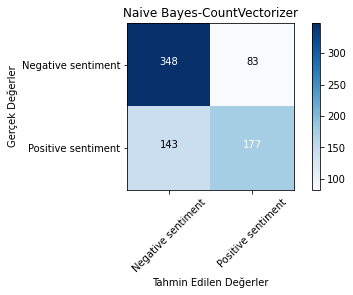

In [63]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Naive Bayes-CountVectorizer')

In [64]:
nb_model = nb.fit(x_train_tf_idf,y_train) #Naive Bayes - tf-idf

y_pred = nb_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76       431
           1       0.71      0.44      0.54       320

    accuracy                           0.68       751
   macro avg       0.69      0.65      0.65       751
weighted avg       0.69      0.68      0.67       751



In [65]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = nb.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  #round

Normalleştirme Olmadan Karmaşıklık Matrisi
[[374  57]
 [180 140]]


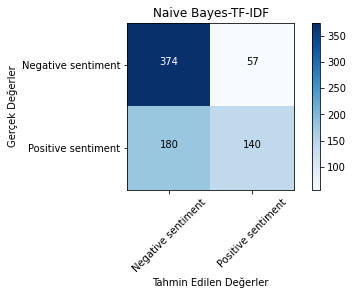

In [66]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Naive Bayes-TF-IDF')

**2 - Random Forest**

In [67]:
rf = RandomForestClassifier() #RandomForest-countvectorizer
rf_model = rf.fit(x_train_count,y_train)

y_pred = rf_model.predict(x_test_count)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.86      0.75       431
           1       0.69      0.42      0.52       320

    accuracy                           0.67       751
   macro avg       0.68      0.64      0.63       751
weighted avg       0.68      0.67      0.65       751



In [68]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = rf.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[371  60]
 [187 133]]


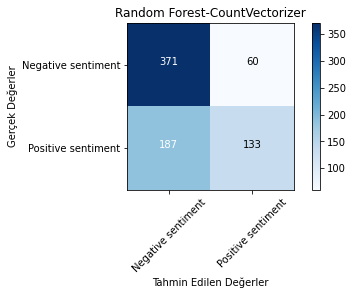

In [69]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Random Forest-CountVectorizer')

In [70]:
rf_model = rf.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = rf_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       431
           1       0.64      0.49      0.56       320

    accuracy                           0.67       751
   macro avg       0.66      0.64      0.65       751
weighted avg       0.66      0.67      0.66       751



In [71]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = rf.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[343  88]
 [162 158]]


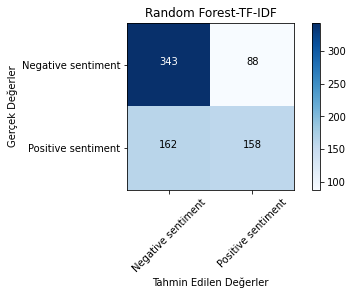

In [72]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Random Forest-TF-IDF')

**3 - Support Vector Machine**

In [73]:
svm = LinearSVC() #Support Vector Machine
svm_model = svm.fit(x_train_count,y_train)

y_pred = svm_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       431
           1       0.63      0.56      0.59       320

    accuracy                           0.68       751
   macro avg       0.67      0.66      0.66       751
weighted avg       0.67      0.68      0.67       751



In [74]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = svm.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  #round

Normalleştirme Olmadan Karmaşıklık Matrisi
[[328 103]
 [141 179]]


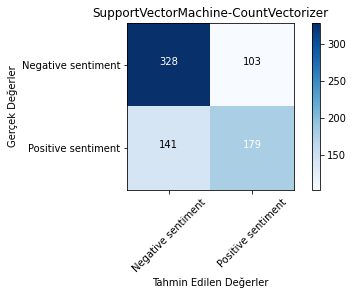

In [75]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='SupportVectorMachine-CountVectorizer')

In [76]:
svm_model = svm.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = svm_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       431
           1       0.67      0.56      0.61       320

    accuracy                           0.69       751
   macro avg       0.69      0.68      0.68       751
weighted avg       0.69      0.69      0.69       751



In [77]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = svm.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[341  90]
 [141 179]]


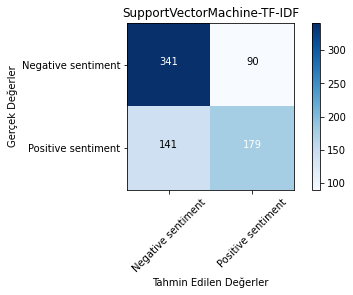

In [78]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='SupportVectorMachine-TF-IDF')

**4 - Decision Tree**

In [79]:
dt = DecisionTreeClassifier() #Decision Tree
dt_model = dt.fit(x_train_count,y_train)

y_pred = dt_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       431
           1       0.59      0.42      0.49       320

    accuracy                           0.63       751
   macro avg       0.62      0.60      0.60       751
weighted avg       0.62      0.63      0.62       751



In [80]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = dt.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  #round

Normalleştirme Olmadan Karmaşıklık Matrisi
[[337  94]
 [184 136]]


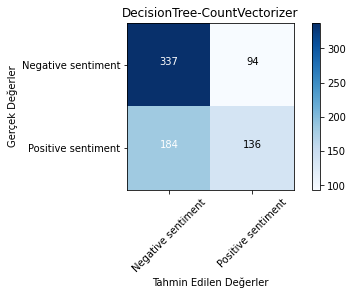

In [81]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='DecisionTree-CountVectorizer')

In [82]:
dt_model = dt.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = dt_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       431
           1       0.54      0.51      0.52       320

    accuracy                           0.61       751
   macro avg       0.60      0.60      0.60       751
weighted avg       0.61      0.61      0.61       751



In [83]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = dt.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[295 136]
 [158 162]]


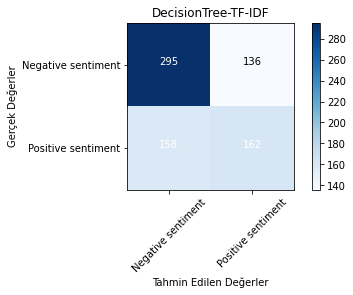

In [84]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='DecisionTree-TF-IDF')

**5 - KNN**

In [85]:
knn = KNeighborsClassifier() #knn
knn_model = knn.fit(x_train_count,y_train)

y_pred = knn_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.94      0.74       431
           1       0.68      0.17      0.27       320

    accuracy                           0.61       751
   macro avg       0.64      0.55      0.50       751
weighted avg       0.63      0.61      0.54       751



In [86]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = knn.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  #round

Normalleştirme Olmadan Karmaşıklık Matrisi
[[405  26]
 [266  54]]


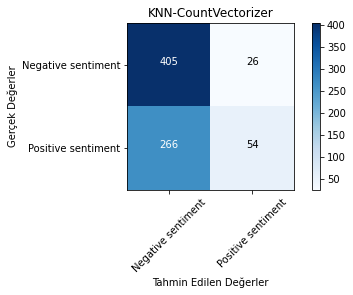

In [87]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='KNN-CountVectorizer')

In [88]:
knn_model = knn.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = knn_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       431
           1       1.00      0.07      0.13       320

    accuracy                           0.60       751
   macro avg       0.80      0.54      0.44       751
weighted avg       0.77      0.60      0.48       751



In [89]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - TF-IDF
import itertools

y_pred = knn.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  #round

Normalleştirme Olmadan Karmaşıklık Matrisi
[[431   0]
 [297  23]]


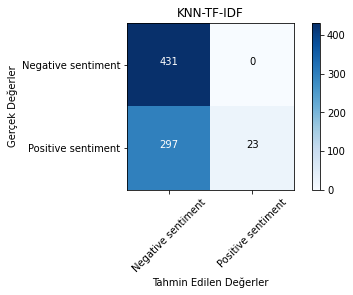

In [90]:
cm_plot_labels=['Negative sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='KNN-TF-IDF')